<h1>Table of Contents</h1>
<ul>
  <li><a href="#section1">1. Import Necessary Libraries</a></li>
  <li><a href="#section2">2. Load Data</a></li>
  <li><a href="#section3">3. Data Preprocessing</a></li>
  <li><a href="#section4">4. Define Model Components</a></li>
  <li><a href="#section5">5. Build and Configure Model</a></li>
  <li><a href="#section6">6. Prepare Data Sample</a></li>
  <li><a href="#section7">7. Model Fitting</a></li>
  <li><a href="#section8">8. Visualization and Analysis</a>
    <ul>
      <li><a href="#section8_1">8.1 Model Fit Diagnostics</a></li>
      <li><a href="#section8_2">8.2 Interactive Parameter Tuning</a></li>
      <li><a href="#section8_3">8.3 Reaction Time PDF Comparison</a></li>
      <li><a href="#section8_4">8.4 Decision Variable Distribution</a></li>
      <li><a href="#section8_5">8.5 Cumulative Distribution Function (CDF)</a></li>
      <li><a href="#section8_6">8.6 Chronometric Analysis</a></li>
    </ul>
  </li>
</ul>


<a id="section1"></a>
# 1. Import Necessary Libraries

In [3]:
import os                # For operating system-related functions (e.g., setting environment variables)
import pandas as pd      # For data processing and tabular operations
import numpy as np       # For numerical computations and array operations
import pyddm             # pyddm is used for building and fitting the DDM
from pyddm import Sample
import pyddm.plot        # Import pyddm.plot first
import matplotlib
matplotlib.use('TkAgg')  # Set default backend to TkAgg
import matplotlib.pyplot as plt
from IPython.display import Image  # For handling and displaying images
from PIL import Image     

In [5]:
# Improve performance: Disable file validation and development mode (use only when debugging is complete)
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'  # Disable file validation to speed up execution
os.environ['PYTHONDEVMODE'] = 'off'                # Disable development mode to avoid unnecessary warnings

<a id="section2"></a>
# 2. Load Data

In [8]:
# Load the experimental data from the specified path. The data includes subject ID, trial number, reaction time, response, etc.
file_path = '/Users/wangyue/Desktop/data/incon_6Frame/HDDM_InconStim_6Frame.csv'  # Replace with your actual file path
data_F = pd.read_csv(file_path)  # Read the CSV file into a pandas DataFrame

<a id="section3"></a>
# 3. Data Preprocessing

In [11]:
# Extract the columns needed for modeling and create a copy to avoid modifying the original data
data_for_model = data_F[['subj_idx', 'trial', 'rt', 'response', 'HSF_emo', 'task']].copy()
# Save the original categorical variables for later analysis (HSF_emo represents emotional state, task represents task type)
data_for_model['task_original'] = data_for_model['task']       # Original task type
data_for_model['HSF_emo_original'] = data_for_model['HSF_emo'] # Original emotional state

In [13]:
# Convert categorical variables (task and HSF_emo) into dummy variables for model processing
data_for_model = pd.get_dummies(data_for_model, columns=['task', 'HSF_emo'], prefix=['task', 'HSF_emo'])

In [15]:
# Analyze the distribution of reaction times (RT) to check basic statistical features
print("Reaction Time Statistics:")
print(data_for_model['rt'].describe())  # Displays mean, quartiles, min, max, etc.

Reaction Time Statistics:
count    9750.000000
mean        0.828259
std         0.467399
min         0.010953
25%         0.584762
50%         0.714717
75%         0.909147
max         9.255789
Name: rt, dtype: float64


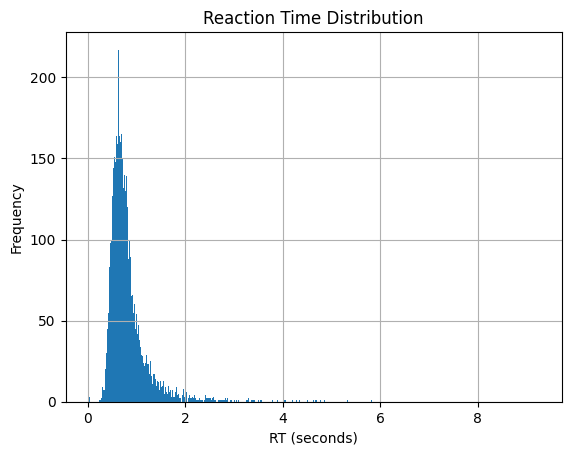

In [17]:
# Visualize RT distribution: Plot a histogram to observe central tendencies and outliers
%matplotlib inline  
data_for_model['rt'].hist(bins=1000)  # Use 1000 bins for fine-grained distribution
plt.title('Reaction Time Distribution')  # Plot title
plt.xlabel('RT (seconds)')              # X-axis label
plt.ylabel('Frequency')                 # Y-axis label
plt.show()  # Display the plot
# Note: Most RTs are concentrated between 0-5 seconds, but there may be rare outliers (e.g., 5-70 seconds)

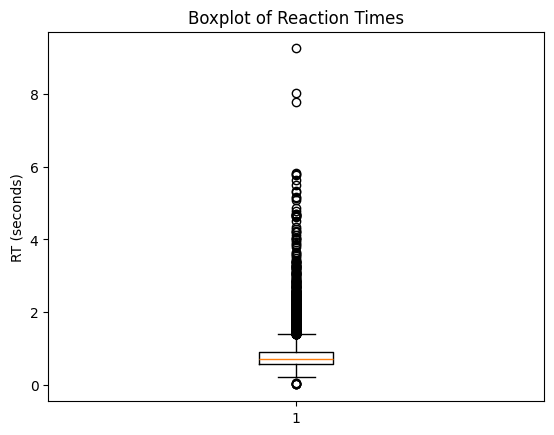

In [18]:
# Use a boxplot to further confirm outliers
plt.boxplot(data_for_model['rt'])  # Boxplot shows median, quartiles, and outliers
plt.title('Boxplot of Reaction Times')
plt.ylabel('RT (seconds)')
plt.show()
# Note: The boxplot may show points significantly deviating from the normal range (e.g., RT > 5 seconds)

In [21]:
# Filter outliers: Keep only data with RT less than 5 seconds to avoid model fitting being affected by extreme values
rt_threshold = 5.0  # Set threshold to 5 seconds
data_for_model_filtered = data_for_model[data_for_model['rt'] < rt_threshold]
print("Filtered Reaction Time Statistics:", data_for_model_filtered['rt'].describe())


Filtered Reaction Time Statistics: count    9737.000000
mean        0.821185
std         0.423111
min         0.010953
25%         0.584603
50%         0.714277
75%         0.908068
max         4.860230
Name: rt, dtype: float64


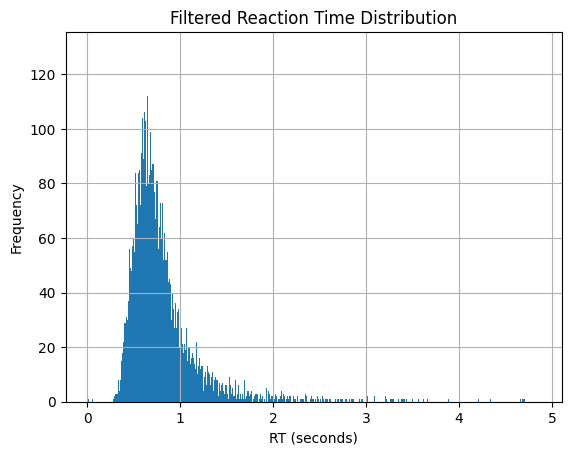

In [23]:
# Visualize the filtered RT distribution
data_for_model_filtered['rt'].hist(bins=1000)
plt.title('Filtered Reaction Time Distribution')
plt.xlabel('RT (seconds)')
plt.ylabel('Frequency')
plt.show()

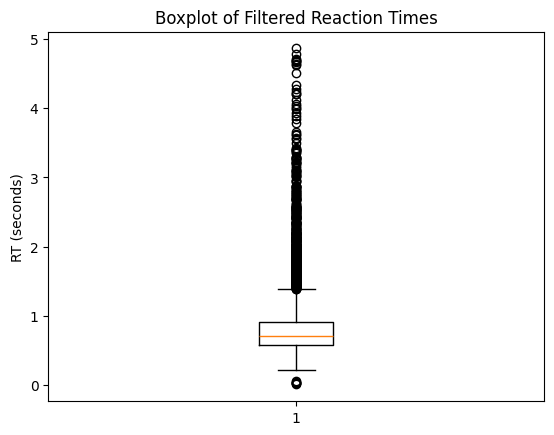

In [24]:
# Check if there are still outliers in the filtered data
plt.boxplot(data_for_model_filtered['rt'])
plt.title('Boxplot of Filtered Reaction Times')
plt.ylabel('RT (seconds)')
plt.show()

<a id="section4"></a>
# 4. Define Model Components

In [28]:
# Define custom functions for drift rate, bound, and starting position in Model 3
def drift_function(HSF_emo_1, HSF_emo_2, drift_emo1, drift_emo2, leak, t, x):
    """
    Drift rate function for Model 3: Depends on HSF emotion with a leaky integrator.
    Parameters:
        HSF_emo_1, HSF_emo_2: Dummy variables for HSF emotion (Fearful, Neutral)
        drift_emo1, drift_emo2: Drift parameters for each HSF emotion
        leak: Leak parameter for evidence decay
        t: Time variable (not used directly)
        x: Current evidence level
    Returns:
        Drift rate array matching the shape of x
    """
    base_drift = (drift_emo1 * HSF_emo_1 + drift_emo2 * HSF_emo_2)
    drift = base_drift - leak * x
    if np.any(np.isnan(drift)) or np.any(np.isinf(drift)):
        print(f"Model 3: Drift function error: {drift}")
    return drift * np.ones_like(x)

In [30]:
def bound_function(threshold, invtau, t):
    """
    Bound function for Model 3: Exponentially decaying decision boundary.
    Parameters:
        threshold: Initial decision threshold
        invtau: Inverse decay rate for the threshold
        t: Time variable
    Returns:
        Decision boundary value at time t
    """
    bound = threshold * np.exp(-t * invtau)
    if np.any(np.isnan(bound)) or np.any(np.isinf(bound)):
        print(f"Model 3: Bound function error: {bound}")
    return bound

In [32]:
def starting_position_function(task_1, task_2, task_3, sp1, sp2, sp3):
    """
    Starting position function for Model 3: Depends on task type.
    Parameters:
        task_1, task_2, task_3: Dummy variables for task type (FvN, FvNot, NvNot)
        sp1, sp2, sp3: Starting position parameters for each task
    Returns:
        Starting position for the decision process
    """
    starting_position = sp1 * task_1 + sp2 * task_2 + sp3 * task_3
    if np.any(np.isnan(starting_position)) or np.any(np.isinf(starting_position)):
        print(f"Model 3: Starting_position function error: {starting_position}")
    return starting_position

<a id="section5"></a>
# 5. Build and Configure Model

In [35]:
# 5. Build and Inconfigure Model
# Build and configure Model 3 with drift dependent on HSF_emo and starting position dependent on task
model_3 = pyddm.gddm(
    drift=drift_function,           # Use the custom HSF_emo-dependent drift function
    noise=1.0,                      # Fixed noise level for the diffusion process
    bound=bound_function,           # Use the custom exponential decay bound function
    nondecision="nt",               # Non-decision time parameter
    starting_position=starting_position_function,  # Use the custom task-dependent starting position function
    parameters={
        "drift_emo1": (0, 2),       # Range for drift parameter under HSF_emo_1 condition
        "drift_emo2": (-1, 0),      # Range for drift parameter under HSF_emo_2 condition
        "threshold": (0.3, 1.2),      # Range for initial decision threshold
        "sp1": (-0.3, 0.1), "sp2": (-0.2, 0.2), "sp3": (-0.2, 0.2),  # Ranges for starting position parameters for each task condition
        "nt": (0.1, 1),             # Range for non-decision time
        "leak": (0.001, 0.04),      # Range for leak parameter in the integrator
        "invtau": (0.1, 0.5)          # Range for decay rate in the bound function
    },
    conditions=["task_1", "task_2", "task_3", "HSF_emo_1", "HSF_emo_2"],  # Specify task and HSF_emo dummy variables as conditions
    T_dur=5.0  # Simulation duration in seconds
)

<a id="section6"></a>
# 6. Prepare Data Sample

In [38]:
# Convert the filtered data into a pyddm Sample object for model fitting
data_sample_filtered = Sample.from_pandas_dataframe(
    data_for_model_filtered, 
    rt_column_name='rt',         # Reaction time column
    choice_column_name='response' # Response column (0 or 1)
)

<a id="section7"></a>
# 7. Model Fitting

In [41]:
# Fit Model 3 to the data using BIC as the loss function
try:
    model_3.fit(data_sample_filtered, lossfunction=pyddm.LossBIC, verbose=True)
except Exception as e:
    print(f"Model 3: Error during model fitting: {e}")
    print(f"Model 3: Current model parameters: {model_3.parameters}")

Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.4532285450245762, minval=0, maxval=2), drift_emo2=Fitted(-0.36198844757260284, minval=-1, maxval=0), leak=Fitted(0.03305445427952953, minval=0.001, maxval=0.04)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.016557627050732, minval=0.3, maxval=1.2), invtau=Fitted(0.3135102502117185, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(-0.17340862369284915, minval=-0.3, maxval=0.1), sp2=Fitted(-0.0327941939228622, minval=-0.2, maxval=0.2), sp3=Fitted(0.062200232117891656, minval=-0.2, maxval=0.2)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.7124914759735049, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=81041.91449451349
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.9120823466560418, minval=0, maxval=2), drift_emo2=Fitted(-0.03813529431520579, minval=-1, maxval=0), leak=Fitted(0.029711744513347793, minval=0.001

differential_evolution step 1: f(x)= 15134.608515801285


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.7210943552770984, minval=0, maxval=2), drift_emo2=Fitted(-0.12181568077340299, minval=-1, maxval=0), leak=Fitted(0.019883730225001447, minval=0.001, maxval=0.04)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9906069562912723, minval=0.3, maxval=1.2), invtau=Fitted(0.1928623831475565, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.035356964072471866, minval=-0.3, maxval=0.1), sp2=Fitted(0.0636714065443638, minval=-0.2, maxval=0.2), sp3=Fitted(0.05238213645884265, minval=-0.2, maxval=0.2)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.30903487294417886, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=16929.09230911404
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.6116198102455712, minval=0, maxval=2), drift_emo2=Fitted(-0.2504253042717387, minval=-1, maxval=0), leak=Fitted(0.016917452322991203, minval=0.001

differential_evolution step 2: f(x)= 14947.33708393667


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.0851809650712325, minval=0, maxval=2), drift_emo2=Fitted(-0.3976692112606648, minval=-1, maxval=0), leak=Fitted(0.016118925282052936, minval=0.001, maxval=0.04)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.0053603356063041, minval=0.3, maxval=1.2), invtau=Fitted(0.2634047932133837, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(-0.0865185931169161, minval=-0.3, maxval=0.1), sp2=Fitted(0.14549352618690686, minval=-0.2, maxval=0.2), sp3=Fitted(-0.06268359205129574, minval=-0.2, maxval=0.2)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3127040261871549, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=16281.178732614362
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.3315301800418435, minval=0, maxval=2), drift_emo2=Fitted(-0.358439976392818, minval=-1, maxval=0), leak=Fitted(0.022674505371105123, minval=0.001,

differential_evolution step 3: f(x)= 14581.25427814916


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.826935007853944, minval=0, maxval=2), drift_emo2=Fitted(-0.5006970400271167, minval=-1, maxval=0), leak=Fitted(0.016118925282052936, minval=0.001, maxval=0.04)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9000692629349341, minval=0.3, maxval=1.2), invtau=Fitted(0.4930094532665376, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(-0.18477744712063313, minval=-0.3, maxval=0.1), sp2=Fitted(0.004769744737227555, minval=-0.2, maxval=0.2), sp3=Fitted(0.05450598490989185, minval=-0.2, maxval=0.2)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3127040261871549, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15682.642731308812
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.6116198102455712, minval=0, maxval=2), drift_emo2=Fitted(-0.2504253042717387, minval=-1, maxval=0), leak=Fitted(0.016917452322991203, minval=0.001

differential_evolution step 4: f(x)= 14509.777435972368


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.826935007853944, minval=0, maxval=2), drift_emo2=Fitted(-0.5006970400271167, minval=-1, maxval=0), leak=Fitted(0.027887077281444576, minval=0.001, maxval=0.04)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9000692629349341, minval=0.3, maxval=1.2), invtau=Fitted(0.3525396269847386, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(-0.18477744712063313, minval=-0.3, maxval=0.1), sp2=Fitted(0.004769744737227555, minval=-0.2, maxval=0.2), sp3=Fitted(0.12796966743203872, minval=-0.2, maxval=0.2)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2708436145795401, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=16428.227572226435
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.6960571898030268, minval=0, maxval=2), drift_emo2=Fitted(-0.24191598538253978, minval=-1, maxval=0), leak=Fitted(0.028584869733436442, minval=0.00

differential_evolution step 5: f(x)= 14457.831782629006


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.826935007853944, minval=0, maxval=2), drift_emo2=Fitted(-0.44326877934414044, minval=-1, maxval=0), leak=Fitted(0.01941641378299219, minval=0.001, maxval=0.04)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7835723156930641, minval=0.3, maxval=1.2), invtau=Fitted(0.2935857870091883, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(-0.0110322240750836, minval=-0.3, maxval=0.1), sp2=Fitted(-0.10117843721563591, minval=-0.2, maxval=0.2), sp3=Fitted(0.10794667542603538, minval=-0.2, maxval=0.2)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.33308883622622054, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15864.297084332915
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.7093623767122552, minval=0, maxval=2), drift_emo2=Fitted(-0.24191598538253978, minval=-1, maxval=0), leak=Fitted(0.02261768334695024, minval=0.001

differential_evolution step 6: f(x)= 14438.869682606008


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.122668531472593, minval=0, maxval=2), drift_emo2=Fitted(-0.5006970400271167, minval=-1, maxval=0), leak=Fitted(0.022800406737145573, minval=0.001, maxval=0.04)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9000692629349341, minval=0.3, maxval=1.2), invtau=Fitted(0.35783257962599563, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.005959895921247876, minval=-0.3, maxval=0.1), sp2=Fitted(0.10542115799093797, minval=-0.2, maxval=0.2), sp3=Fitted(-0.15763829145237304, minval=-0.2, maxval=0.2)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3116219752437265, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14726.388483836776
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.6960571898030268, minval=0, maxval=2), drift_emo2=Fitted(-0.24191598538253978, minval=-1, maxval=0), leak=Fitted(0.029545350419832927, minval=0.0

differential_evolution step 7: f(x)= 14438.869682606008


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.1813089845316023, minval=0, maxval=2), drift_emo2=Fitted(-0.2878227101382297, minval=-1, maxval=0), leak=Fitted(0.033290315215809226, minval=0.001, maxval=0.04)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.784447082827135, minval=0.3, maxval=1.2), invtau=Fitted(0.22522504483522088, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.030469299373878975, minval=-0.3, maxval=0.1), sp2=Fitted(0.1061027503406784, minval=-0.2, maxval=0.2), sp3=Fitted(-0.075125714382725, minval=-0.2, maxval=0.2)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.31736814290107496, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14533.829096706753
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.9012661143574434, minval=0, maxval=2), drift_emo2=Fitted(-0.45405155946453046, minval=-1, maxval=0), leak=Fitted(0.010659237532768203, minval=0.001

differential_evolution step 8: f(x)= 14438.869682606008


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.1595054967919378, minval=0, maxval=2), drift_emo2=Fitted(-0.5966387026399236, minval=-1, maxval=0), leak=Fitted(0.02595351190729981, minval=0.001, maxval=0.04)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7169582826830131, minval=0.3, maxval=1.2), invtau=Fitted(0.26801103887157224, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.030469299373878975, minval=-0.3, maxval=0.1), sp2=Fitted(0.10243609863626202, minval=-0.2, maxval=0.2), sp3=Fitted(-0.075125714382725, minval=-0.2, maxval=0.2)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.37359621727948644, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15184.575994374987
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.6960571898030268, minval=0, maxval=2), drift_emo2=Fitted(-0.24191598538253978, minval=-1, maxval=0), leak=Fitted(0.01673287728821795, minval=0.001

differential_evolution step 9: f(x)= 14397.68667464295


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.6960571898030268, minval=0, maxval=2), drift_emo2=Fitted(-0.3581728791169956, minval=-1, maxval=0), leak=Fitted(0.028584869733436442, minval=0.001, maxval=0.04)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7906766727676798, minval=0.3, maxval=1.2), invtau=Fitted(0.2785690670802467, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.0343668602825286, minval=-0.3, maxval=0.1), sp2=Fitted(-0.05218135988789041, minval=-0.2, maxval=0.2), sp3=Fitted(0.07011983122287124, minval=-0.2, maxval=0.2)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.30347267362220764, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14933.739898720301
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.9890026646614948, minval=0, maxval=2), drift_emo2=Fitted(-0.48426632518284174, minval=-1, maxval=0), leak=Fitted(0.036117383527945496, minval=0.00

differential_evolution step 10: f(x)= 14324.174396248722


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.5590356137208397, minval=0, maxval=2), drift_emo2=Fitted(-0.4594288556765235, minval=-1, maxval=0), leak=Fitted(0.033290315215809226, minval=0.001, maxval=0.04)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8063287410693855, minval=0.3, maxval=1.2), invtau=Fitted(0.3654588723832676, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.030469299373878975, minval=-0.3, maxval=0.1), sp2=Fitted(0.12199881288602077, minval=-0.2, maxval=0.2), sp3=Fitted(-0.07402858235203494, minval=-0.2, maxval=0.2)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3550354201768566, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15193.91990939549
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.6960571898030268, minval=0, maxval=2), drift_emo2=Fitted(-0.2554028412967795, minval=-1, maxval=0), leak=Fitted(0.03129904441143683, minval=0.001,

differential_evolution step 11: f(x)= 14324.174396248722
Polishing solution with 'L-BFGS-B'


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.0609244755731755, minval=0, maxval=2), drift_emo2=Fitted(-0.401561501332375, minval=-1, maxval=0), leak=Fitted(0.02470274847508203, minval=0.001, maxval=0.04)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8548944597109174, minval=0.3, maxval=1.2), invtau=Fitted(0.32713279554952446, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.006266952439718684, minval=-0.3, maxval=0.1), sp2=Fitted(0.05759438109276865, minval=-0.2, maxval=0.2), sp3=Fitted(-0.01694170023974617, minval=-0.2, maxval=0.2)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3176892679106188, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14324.17439595986
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.0609244655731755, minval=0, maxval=2), drift_emo2=Fitted(-0.401561491332375, minval=-1, maxval=0), leak=Fitted(0.02470274847508203, minval=0.001, m

In [42]:
model_3.show()  # Display fitted model parameters

Model information:
Choices: 'correct' (upper boundary), 'error' (lower boundary)
Drift component DriftEasy:
    easy_drift
    Fitted parameters:
    - drift_emo1: 1.061212
    - drift_emo2: -0.401439
    - leak: 0.024696
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundEasy:
    easy_bound
    Fitted parameters:
    - threshold: 0.855000
    - invtau: 0.327186
IC component ICPointRatioEasy:
    easy_starting_point
    Fitted parameters:
    - sp1: 0.006267
    - sp2: 0.057594
    - sp3: -0.016942
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.317689
    Overlay component OverlayUniformMixture:
        Uniform distribution mixture model
        Fixed parameters:
        - umixturecoef: 0.020000
Fit information:
    Loss function: BIC
    Loss function value: 14324.079239042563
    Fitting method: d

<a id="section8"></a>
# 8. Visualization and Analysis

<a id="section8_1"></a>
## 8.1 Model Fit Diagnostics

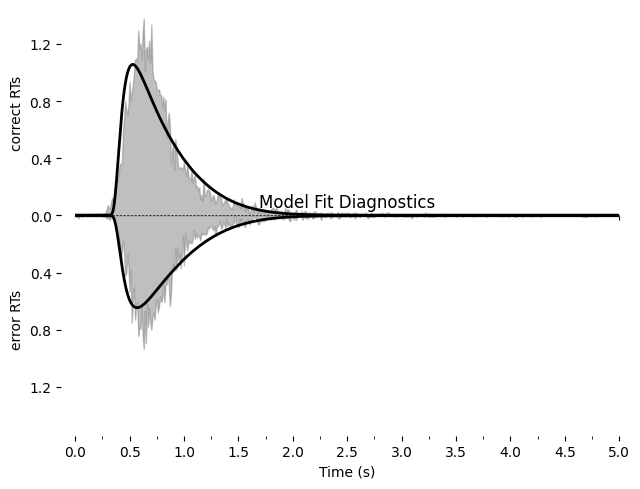

In [144]:
%matplotlib inline
pyddm.plot.plot_fit_diagnostics(model=model_3, sample=data_sample_filtered)
plt.xlim(0, 5)  # Limit x-axis to match data range
plt.title('Model Fit Diagnostics')
plt.show()
# Note: This plot compares the model's predicted RT distribution with the actual data to assess fit quality

In [146]:
# Use Tkinter-based GUI for interactive parameter adjustment
%gui tk
pyddm.plot.model_gui(
    model=model_3,                # Model 3
    sample=data_sample_filtered,  # Actual data
    data_dt=0.01,                 # Default bin width
    plot=pyddm.plot.plot_fit_diagnostics,  # Default plotting function
    conditions=None,              # Infer conditions from sample
    verify=False                  # Disable verification for performance
)

[{'0': np.int64(0), '1': np.int64(1)}, {'0': np.int64(0), '1': np.int64(1)}, {'0': np.int64(0), '1': np.int64(1)}, {'0': np.int64(0), '1': np.int64(1)}, {'0': np.int64(0), '1': np.int64(1)}]


2025-05-27 14:00:21.258 python[9661:8723564] +[IMKClient subclass]: chose IMKClient_Modern
2025-05-27 14:00:21.258 python[9661:8723564] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.93, minval=0, maxval=2), drift_emo2=Fitted(-0.4, minval=-1, maxval=0), leak=Fitted(0.0102, minval=0.001, maxval=0.04)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.858, minval=0.3, maxval=1.2), invtau=Fitted(0.372, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.028, minval=-0.3, maxval=0.1), sp2=Fitted(0.084, minval=-0.2, maxval=0.2), sp3=Fitted(0.006, minval=-0.2, maxval=0.2)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3142682682440902, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0, fitresult=FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=np.float64(14322.788964097579), nparams=9, samplesize=9737, mess=''))

<a id="section8_2"></a>
## 8.2 Interactive Parameter Tuning

In [161]:
# This allows you to tweak model parameters and see the effects in real-time in a separate window
%gui tk  # Enable Tkinter GUI backend
pyddm.plot.model_gui(
    model=model_3,                # The model to adjust
    sample=data_sample_filtered,  # The actual data sample
    data_dt=0.01,                 # Default bin width for data
    plot=pyddm.plot.plot_fit_diagnostics,  # Use fit diagnostics plot
    conditions=None,              # Infer conditions from the sample
    verify=False                  # Disable verification for better performance
)
# Note: This will open a separate window where you can adjust parameters and see the model fit update dynamically 

Error:root:Invalid GUI request 'tk # Enable Tkinter GUI backend', valid ones are:dict_keys(['inline', 'nbagg', 'webagg', 'notebook', 'ipympl', 'widget', None, 'qt', 'qt5', 'qt6', 'wx', 'tk', 'gtk', 'gtk3', 'osx', 'asyncio'])


[{'0': np.int64(0), '1': np.int64(1)}, {'0': np.int64(0), '1': np.int64(1)}, {'0': np.int64(0), '1': np.int64(1)}, {'0': np.int64(0), '1': np.int64(1)}, {'0': np.int64(0), '1': np.int64(1)}]


Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.93, minval=0, maxval=2), drift_emo2=Fitted(-0.4, minval=-1, maxval=0), leak=Fitted(0.0102, minval=0.001, maxval=0.04)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.858, minval=0.3, maxval=1.2), invtau=Fitted(0.372, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.028, minval=-0.3, maxval=0.1), sp2=Fitted(0.084, minval=-0.2, maxval=0.2), sp3=Fitted(0.006, minval=-0.2, maxval=0.2)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3142682682440902, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0, fitresult=FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=np.float64(14322.788964097579), nparams=9, samplesize=9737, mess=''))

In [149]:
# Interactive Parameter Tuning (Jupyter)
# Use pyddm.plot.model_gui_jupyter for interactive parameter adjustment within the Jupyter Notebook
pyddm.plot.model_gui_jupyter(
    model=model_3,                # The model to adjust
    sample=data_sample_filtered,  # The actual data sample
    data_dt=0.01,                 # Time step for data binning
    plot=pyddm.plot.plot_fit_diagnostics,  # Use diagnostic plot for visualization
    conditions=None,              # Automatically infer conditions from data
    verify=False                  # Disable verification for better performance
)
# Note: This embeds the interactive GUI directly into the Jupyter Notebook for easier use


Output()

<a id="section8_3"></a>
## 8.3 Reaction Time PDF Comparison

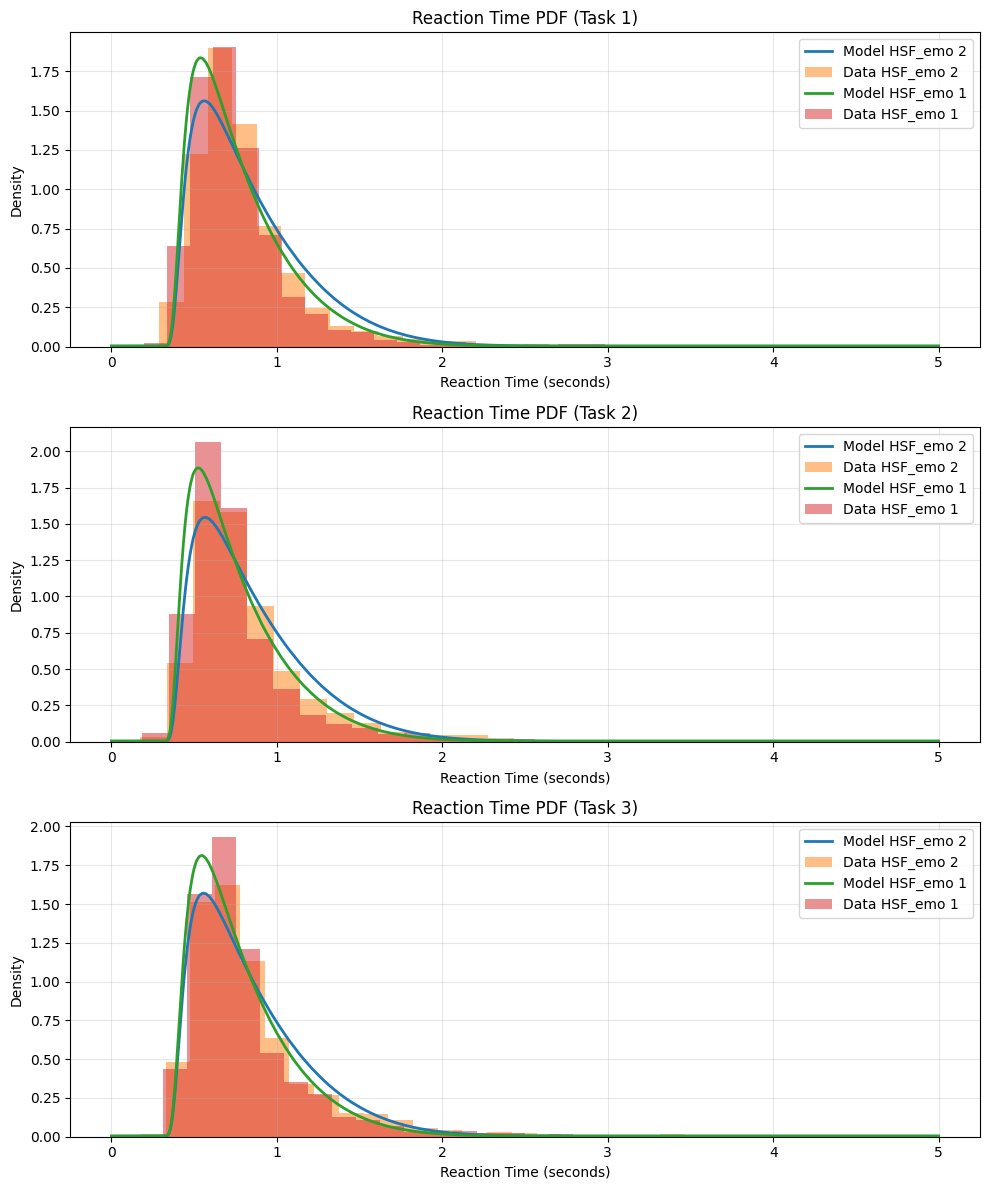

In [87]:
# Custom function to plot model-predicted reaction time probability density functions (PDFs)
def plot_solution_pdf(model, conditions, ax=None, label=None):
    """
    Plot the model-predicted reaction time PDF, combining correct (choice=1) and error (choice=0) responses.

    This function solves a Drift Diffusion Model (DDM) for given conditions and plots the combined PDF of reaction times,
    representing the probability density of decision times across both response types.

    Args:
        model (pyddm.Model): Fitted DDM model containing parameters and simulation settings.
        conditions (dict): Dictionary specifying task and emotional state conditions
                           (e.g., {'task_1': 1, 'HSF_emo_1': 0}).
        ax (matplotlib.axes.Axes, optional): Matplotlib axis to plot on. If None, a new figure and axis are created.
        label (str, optional): Label for the plotted PDF line in the legend.

    Returns:
        matplotlib.axes.Axes: The axis containing the plotted PDF.
    """
    # Create a new figure and axis if none provided
    if ax is None:
        fig, ax = plt.subplots()

    # Solve the model for the specified conditions to obtain the solution distribution
    sol = model.solve(conditions=conditions)

    # Generate a time grid for the PDF, spanning from 0 to the model's maximum duration
    t = np.linspace(0, model.T_dur, len(sol.pdf(1)))

    # Extract PDFs for correct (upper boundary, choice=1) and error (lower boundary, choice=0) responses
    pdf_choice_1 = sol.pdf(1)
    pdf_choice_0 = sol.pdf(0)

    # Combine PDFs to represent the total reaction time distribution
    pdf_combined = pdf_choice_1 + pdf_choice_0

    # Plot the combined PDF with specified label and line width
    ax.plot(t, pdf_combined, label=label, linewidth=2)

    return ax

### 8.3 Reaction Time PDF Comparison ###
def plot_compare_solutions_with_data(model, data, hsf_emo_values, task_values):
    """
    Plot reaction time PDFs for each task, comparing model predictions with empirical data histograms.

    This function generates a vertical stack of subplots, one for each task, where each subplot displays
    model-predicted PDFs and empirical reaction time histograms for different emotional states (HSF_emo).
    The comparison visualizes how well the DDM model captures the observed reaction time distributions.

    Args:
        model (pyddm.Model): Fitted DDM model used to generate predicted PDFs.
        data (pandas.DataFrame): Filtered dataset containing reaction times and condition labels.
        hsf_emo_values (numpy.ndarray): Unique emotional state values (HSF_emo_original, e.g., [1, 2]).
        task_values (numpy.ndarray): Unique task type values (task_original, e.g., [1, 2, 3]).

    Notes:
        - Task values: 1 (FvN), 2 (FvNot), 3 (NvNot).
        - HSF_emo values: 1 (Fearful), 2 (Neutral).
        - The function assumes 'rt', 'task_original', and 'HSF_emo_original' columns in the data.
    """
    # Determine the number of tasks to create subplots
    num_tasks = len(task_values)
    # Create a figure with vertically stacked subplots, sized proportionally to the number of tasks
    fig, axes = plt.subplots(num_tasks, 1, figsize=(10, 4 * num_tasks))
    # Ensure axes is iterable for a single task
    if num_tasks == 1:
        axes = [axes]

    # Define a helper function to convert task and HSF_emo values into model condition dictionaries
    def get_conditions(task_val, hsf_emo_val):
        """
        Convert task and emotional state values into a dictionary of binary condition variables.

        Args:
            task_val (int): Task identifier (1, 2, or 3).
            hsf_emo_val (int): Emotional state identifier (1 or 2).

        Returns:
            dict: Binary conditions for the DDM model (e.g., {'task_1': 1, 'task_2': 0, ...}).
        """
        return {
            "task_1": 1 if task_val == 1 else 0,
            "task_2": 1 if task_val == 2 else 0,
            "task_3": 1 if task_val == 3 else 0,
            "HSF_emo_1": 1 if hsf_emo_val == 1 else 0,
            "HSF_emo_2": 1 if hsf_emo_val == 2 else 0
        }

    # Iterate over tasks to create subplots
    for i, task in enumerate(task_values):
        ax = axes[i]  # Select the subplot for the current task
        # Iterate over emotional states (Fearful, Neutral)
        for hsf_emo in hsf_emo_values:
            # Generate condition dictionary for the current task and emotional state
            conditions = get_conditions(task, hsf_emo)

            # Plot model-predicted PDF using the custom function
            plot_solution_pdf(model, conditions, ax=ax, label=f"Model HSF_emo {hsf_emo}")

            # Filter empirical data for the current task and emotional state
            condition_data = data[(data['task_original'] == task) & (data['HSF_emo_original'] == hsf_emo)]
            rt_data = condition_data['rt']
            # Plot histogram of empirical reaction times if data exists
            if len(rt_data) > 0:
                ax.hist(rt_data, bins=30, density=True, alpha=0.5, label=f"Data HSF_emo {hsf_emo}")

        # Customize subplot appearance
        ax.set_title(f"Reaction Time PDF (Task {task})")
        ax.set_xlabel("Reaction Time (seconds)")
        ax.set_ylabel("Density")
        # Add a semi-transparent grid for readability
        ax.grid(True, alpha=0.3)
        # Display legend to distinguish model predictions and data
        ax.legend()

    # Adjust subplot layout to prevent overlap
    plt.tight_layout()
    # Display the figure
    plt.show()

# Extract unique emotional states and tasks from filtered data
hsf_emo_levels = data_for_model_filtered['HSF_emo_original'].unique()
task_levels = data_for_model_filtered['task_original'].unique()
# Define fixed task order for consistent plotting
custom_task_order = [1, 2, 3]  # Task 1: FvN, Task 2: FvNot, Task 3: NvNot
# Call the comparison function with the fitted model and filtered data
plot_compare_solutions_with_data(model_3, data_for_model_filtered, hsf_emo_levels, custom_task_order)

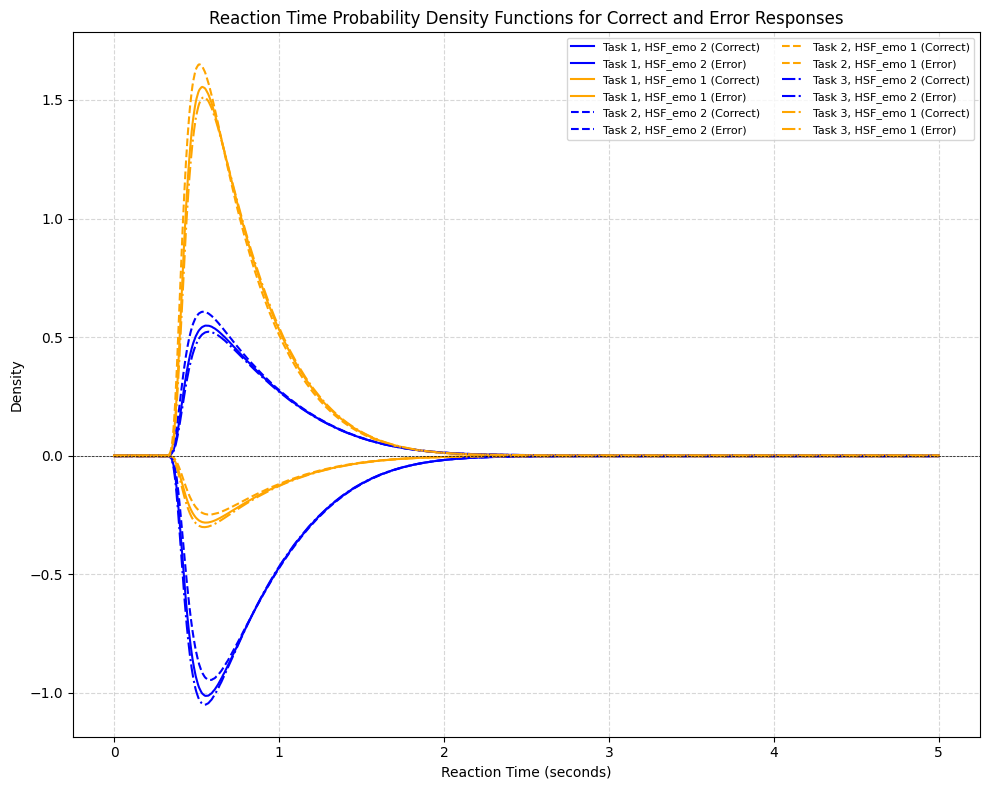

In [89]:
# All Conditions PDF Comparison
# Custom function to plot all fitted PDFs for different conditions in a single figure
def plot_compare_solutions_with_data(model, data, hsf_emo_values, task_values):
    """
    Plot reaction time probability density functions (PDFs) for correct and error responses across all conditions.

    This function generates a single figure displaying separated PDFs for correct (above x-axis) and error (below x-axis)
    responses across different tasks and emotional states, as predicted by a fitted Drift Diffusion Model (DDM).
    The visualization helps evaluate how model predictions vary with task type (FvN, FvNot, NvNot) and emotional state
    (Fearful, Neutral), using distinct colors and line styles.

    Args:
        model (pyddm.Model): Fitted DDM model containing parameters and simulation settings.
        data (pandas.DataFrame): Filtered dataset used to extract unique task and HSF_emo values.
        hsf_emo_values (numpy.ndarray): Unique emotional state values (HSF_emo_original, e.g., [1, 2]).
        task_values (numpy.ndarray): Unique task type values (task_original, e.g., [1, 2, 3]).

    Notes:
        - Task values: 1 (FvN), 2 (FvNot), 3 (NvNot).
        - HSF_emo values: 1 (Fearful), 2 (Neutral).
        - The function assumes 'task_original' and 'HSF_emo_original' columns in the data.
    """
    # Define color mapping for emotional states
    colors = {1: 'orange', 2: 'blue'}  # HSF_emo 1 (Fearful): orange, 2 (Neutral): blue

    # Define line style mapping for tasks
    line_styles = {1: '-', 2: '--', 3: '-.'}  # Task 1: solid, 2: dashed, 3: dashdot

    # Define a helper function to convert task and HSF_emo values into model condition dictionaries
    def get_conditions(task_val, hsf_emo_val):
        """
        Convert task and emotional state values into a dictionary of binary condition variables.

        Args:
            task_val (int): Task identifier (1, 2, or 3).
            hsf_emo_val (int): Emotional state identifier (1 or 2).

        Returns:
            dict: Binary conditions for the DDM model (e.g., {'task_1': 1, 'task_2': 0, ...}).
        """
        return {
            "task_1": 1 if task_val == 1 else 0,
            "task_2": 1 if task_val == 2 else 0,
            "task_3": 1 if task_val == 3 else 0,
            "HSF_emo_1": 1 if hsf_emo_val == 1 else 0,
            "HSF_emo_2": 1 if hsf_emo_val == 2 else 0
        }

    # Create a single figure with increased height to reduce curve overlap
    fig, ax = plt.subplots(figsize=(10, 8))
    # Iterate over all combinations of tasks and emotional states
    for task in task_values:
        for hsf_emo in hsf_emo_values:
            # Generate condition dictionary for the current task and emotional state
            conditions = get_conditions(task, hsf_emo)
            # Solve the model to obtain the solution distribution for the given conditions
            sol = model.solve(conditions=conditions)

            # Generate a time grid spanning the model's duration
            t = np.linspace(0, model.T_dur, len(sol.pdf(1)))  # Time grid based on PDF length

            # Extract PDFs for correct (choice=1) and error (choice=0) responses
            pdf_correct = sol.pdf(1)  # PDF for correct responses (plotted above x-axis)
            pdf_error = -sol.pdf(0)  # PDF for error responses (plotted below x-axis as negative)

            # Assign color based on emotional state and line style based on task
            color = colors[hsf_emo]
            linestyle = line_styles[task]

            # Plot correct PDF with specified color, line style, and label
            ax.plot(t, pdf_correct, label=f"Task {task}, HSF_emo {hsf_emo} (Correct)",
                    color=color, linestyle=linestyle, linewidth=1.5)
            # Plot error PDF with the same color and line style, but as a negative value
            ax.plot(t, pdf_error, label=f"Task {task}, HSF_emo {hsf_emo} (Error)",
                    color=color, linestyle=linestyle, linewidth=1.5)

    # Add a horizontal line at y=0 to visually separate correct and error PDFs
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

    # Set plot title, labels, and customize appearance
    ax.set_title("Reaction Time Probability Density Functions for Correct and Error Responses")
    ax.set_xlabel("Reaction Time (seconds)")
    ax.set_ylabel("Density")
    # Configure legend with two columns and smaller font to reduce clutter
    ax.legend(loc='upper right', ncol=2, fontsize=8)
    # Add a semi-transparent grid for better readability
    ax.grid(True, linestyle='--', alpha=0.5)
    # Adjust layout to prevent overlap of elements
    plt.tight_layout()
    # Display the figure
    plt.show()

# Extract unique emotional states and tasks from filtered data
hsf_emo_levels = data_for_model_filtered['HSF_emo_original'].unique()
task_levels = data_for_model_filtered['task_original'].unique()
# Define fixed task order for consistent plotting
custom_task_order = [1, 2, 3]  # Task 1: FvN, Task 2: FvNot, Task 3: NvNot
# Call the comparison function with the fitted model and filtered data
plot_compare_solutions_with_data(model_3, data_for_model_filtered, hsf_emo_levels, custom_task_order)

<a id="section8_4"></a>
## 8.4 Decision Variable Distribution

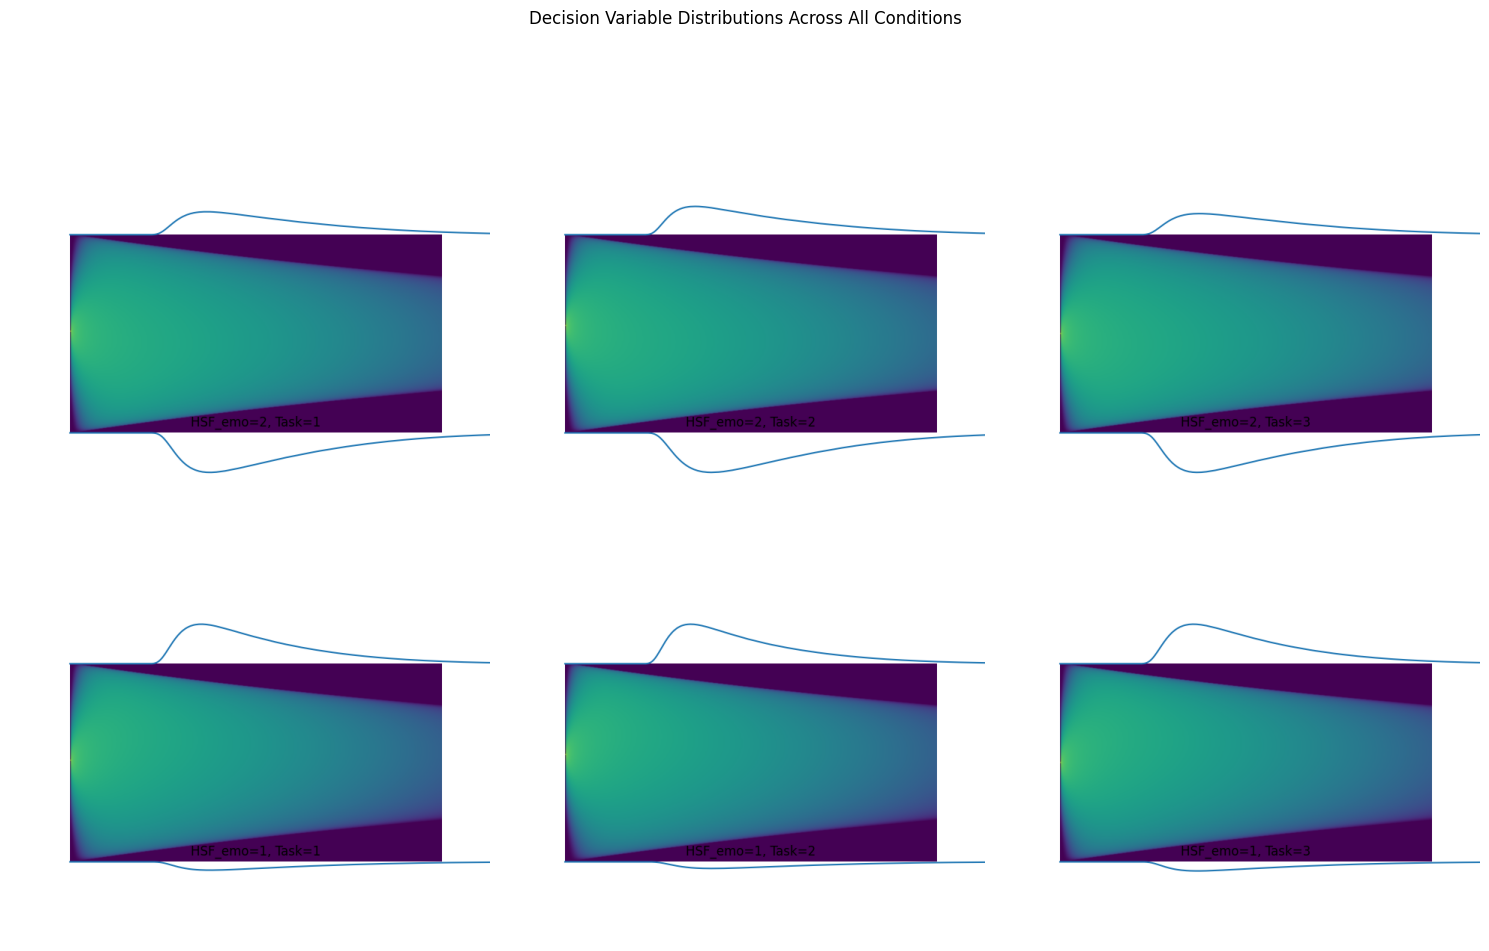

In [155]:
# Custom function: Plot decision variable distributions for all conditions
def plot_decision_variable_distributions(model, hsf_emo_values, task_values):
    """
    Parameters:
        model: Fitted DDM model
        hsf_emo_values: Unique emotional state values
        task_values: Unique task type values
    """
    resolution = 0.05  # Time resolution
    os.makedirs("temp_images", exist_ok=True)  # Create temporary folder for images
    image_files = []

    def get_conditions(task_val, hsf_emo_val):
        return {
            "task_1": 1 if task_val == 1 else 0,
            "task_2": 1 if task_val == 2 else 0,
            "task_3": 1 if task_val == 3 else 0,
            "HSF_emo_1": 1 if hsf_emo_val == 1 else 0,
            "HSF_emo_2": 1 if hsf_emo_val == 2 else 0
        }

    for hsf in hsf_emo_values:
        for task in task_values:
            conditions = get_conditions(task, hsf)
            pyddm.plot.plot_decision_variable_distribution(model=model_3, conditions=conditions, resolution=resolution)
            plt.title(f"HSF_emo={hsf}, Task={task}")
            plt.xlabel("Time (ms)")
            plt.ylabel("Decision Variable (sqrt)")
            plt.xlim(0, 300)  # Limit time range
            file_name = f"temp_images/HSF_{hsf}_Task_{task}.png"
            plt.savefig(file_name)
            plt.close()
            image_files.append(file_name)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2x3 grid for all conditions
    for i, ax in enumerate(axes.flat):
        img = Image.open(image_files[i])
        ax.imshow(img)
        ax.axis('off')

    plt.suptitle("Decision Variable Distributions Across All Conditions", y=1.02)
    plt.tight_layout()
    plt.show()

    # Clean up temporary files
    for file in image_files:
        os.remove(file)
    os.rmdir("temp_images")

# Call the decision variable distribution function
plot_decision_variable_distributions(model_3, hsf_emo_levels, custom_task_order)


<a id="section8_5"></a>
## 8.5 Cumulative Distribution Function (CDF)

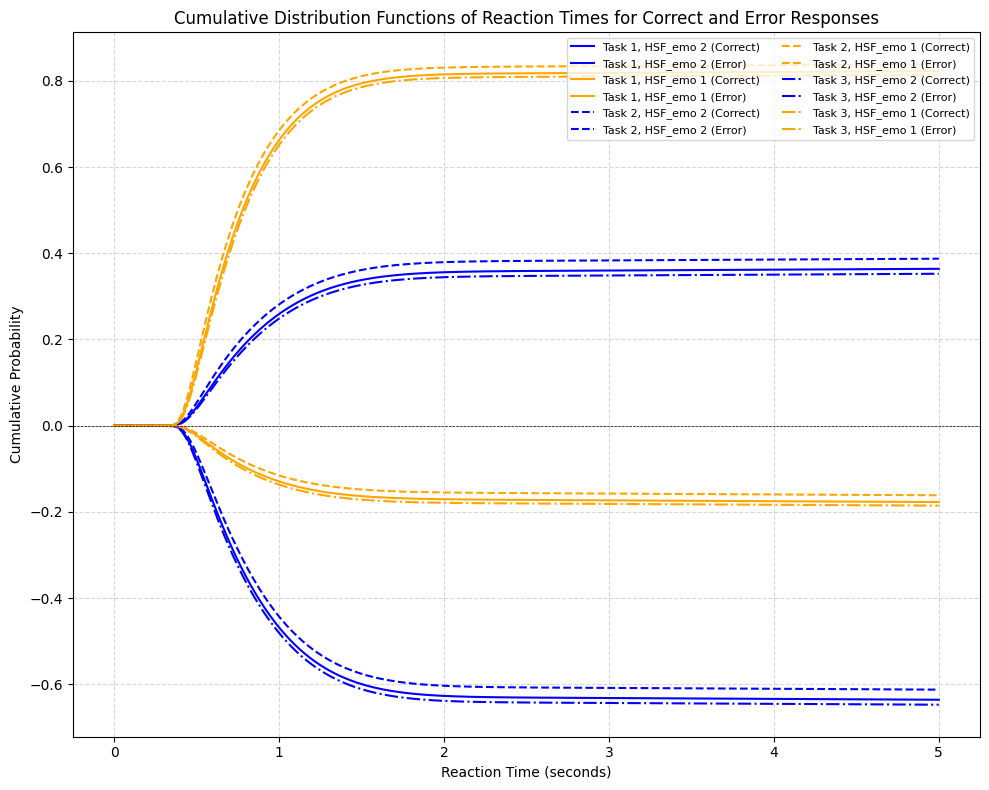

In [95]:
# Custom function to plot cumulative distribution functions (CDFs) of reaction times for all conditions
def plot_compare_solutions_with_data(model, data, hsf_emo_values, task_values):
    """
    Plot cumulative distribution functions (CDFs) of reaction times for correct and error responses across all conditions.

    This function generates a single figure displaying separated CDFs for correct (above x-axis) and error (below x-axis)
    responses across different tasks and emotional states, as predicted by a fitted Drift Diffusion Model (DDM). Correct CDFs
    are plotted using PyDDM's built-in function, while error CDFs are manually plotted as negative values. The visualization
    helps evaluate the model's ability to capture the temporal dynamics of decision-making under varying task and emotional
    conditions, using distinct colors and line styles to differentiate conditions.

    Args:
        model (pyddm.Model): Fitted DDM model containing parameters and simulation settings.
        data (pandas.DataFrame): Filtered dataset used to extract unique task and HSF_emo values.
        hsf_emo_values (numpy.ndarray): Unique emotional state values (HSF_emo_original, e.g., [1, 2]).
        task_values (numpy.ndarray): Unique task type values (task_original, e.g., [1, 2, 3]).

    Notes:
        - Task values: 1 (FvN), 2 (FvNot), 3 (NvNot).
        - HSF_emo values: 1 (Fearful), 2 (Neutral).
        - The function assumes 'task_original' and 'HSF_emo_original' columns in the data.
    """
    # Define color mapping for emotional states
    colors = {1: 'orange', 2: 'blue'}  # HSF_emo 1 (Fearful): orange, 2 (Neutral): blue

    # Define line style mapping for tasks
    line_styles = {1: '-', 2: '--', 3: '-.'}  # Task 1: solid, 2: dashed, 3: dashdot

    # Define a helper function to convert task and HSF_emo values into model condition dictionaries
    def get_conditions(task_val, hsf_emo_val):
        """
        Convert task and emotional state values into a dictionary of binary condition variables.

        Args:
            task_val (int): Task identifier (1, 2, or 3).
            hsf_emo_val (int): Emotional state identifier (1 or 2).

        Returns:
            dict: Binary conditions for the DDM model (e.g., {'task_1': 1, 'task_2': 0, ...}).
        """
        return {
            "task_1": 1 if task_val == 1 else 0,
            "task_2": 1 if task_val == 2 else 0,
            "task_3": 1 if task_val == 3 else 0,
            "HSF_emo_1": 1 if hsf_emo_val == 1 else 0,
            "HSF_emo_2": 1 if hsf_emo_val == 2 else 0
        }

    # Create a single figure with increased height to reduce curve overlap
    fig, ax = plt.subplots(figsize=(10, 8))
    # Lists to store plotted lines and labels for the legend
    lines = []
    labels = []
    # Iterate over all combinations of tasks and emotional states
    for task in task_values:
        for hsf_emo in hsf_emo_values:
            # Generate condition dictionary for the current task and emotional state
            conditions = get_conditions(task, hsf_emo)
            # Solve the model to obtain the solution distribution for the given conditions
            sol = model.solve(conditions=conditions)

            # Plot the CDF for correct responses (choice=1) using PyDDM's built-in function
            pyddm.plot.plot_solution_cdf(sol, ax=ax, correct=True)
            # Customize the correct CDF's appearance (color, line style, width)
            correct_line = ax.get_lines()[-1]  # Get the most recently plotted line
            correct_line.set_color(colors[hsf_emo])
            correct_line.set_linestyle(line_styles[task])
            correct_line.set_linewidth(1.5)
            lines.append(correct_line)
            labels.append(f"Task {task}, HSF_emo {hsf_emo} (Correct)")

            # Manually plot the CDF for error responses (choice=0) below the x-axis
            t = np.linspace(0, model.T_dur, len(sol.cdf(0)))  # Generate time grid based on CDF length
            cdf_error = sol.cdf(0)  # CDF for error responses
            # Plot error CDF as negative to position it below the x-axis, using the same task-specific line style
            line, = ax.plot(t, -cdf_error, color=colors[hsf_emo], linestyle=line_styles[task], linewidth=1.5)
            lines.append(line)
            labels.append(f"Task {task}, HSF_emo {hsf_emo} (Error)")

    # Add a horizontal line at y=0 to visually separate correct and error CDFs
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

    # Set plot title, labels, and customize appearance
    ax.set_title("Cumulative Distribution Functions of Reaction Times for Correct and Error Responses")
    ax.set_xlabel("Reaction Time (seconds)")
    ax.set_ylabel("Cumulative Probability")
    # Configure legend with two columns and smaller font to reduce clutter
    ax.legend(lines, labels, loc='upper right', ncol=2, fontsize=8)
    # Add a semi-transparent grid for better readability
    ax.grid(True, linestyle='--', alpha=0.5)
    # Adjust layout to prevent overlap of elements
    plt.tight_layout()
    # Display the figure
    plt.show()

# Extract unique emotional states and tasks from filtered data
hsf_emo_levels = data_for_model_filtered['HSF_emo_original'].unique()
task_levels = data_for_model_filtered['task_original'].unique()
# Define fixed task order for consistent plotting
custom_task_order = [1, 2, 3]  # Task 1: FvN, Task 2: FvNot, Task 3: NvNot
# Call the comparison function with the fitted model and filtered data
plot_compare_solutions_with_data(model_3, data_for_model_filtered, hsf_emo_levels, custom_task_order)

<a id="section8_6"></a>
## 8.6 Chronometric Analysis

In [159]:
# Use pyddm.plot.model_gui_jupyter with plot_chronometric for analyzing reaction times across conditions
%matplotlib inline
# Call GUI with plot_chronometric
pyddm.plot.model_gui_jupyter(
    model=model_3,                # Your model
    sample=data_sample_filtered,  # Your actual data
    data_dt=0.01,                 # Time bin width
    plot=pyddm.plot.plot_chronometric(
        condition_across="task_original",      # X-axis for original task condition
        split_by_condition="HSF_emo_original", # Split curves by original HSF_emo
        resolution=11                          # Resolution
    ),
    conditions=['task_original', 'HSF_emo_original'],  # Specify conditions for visualization
    verify=False                     # Disable verification for better performance
)
# Note: This provides an interactive way to visualize how reaction times vary across different tasks and emotional states

Output()